In [274]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from skbold.preproc import ConfoundRegressor
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Single confound, confound == y
## 1.1 Regress out confound before K-fold cross-validation
Effectively, confound regression before performing K-fold cross-validation sets the correlation between the confound and X to 0. For illustratory purposes, in Section 1, we assume that y is the confound - or, put alternatively, the correlation between y and the confound is 1.

In Section 1, the simulations vary the 'maximum allowed correlation' between the confound and each independent variable in X. Thus, we do not need to do confound regression before K-fold cross-validation: we can simply look up the case where the 'maximum allowed correlation' is 0. Varying the 'maximum' allowed correlation visualizes the importance of allowing (spurious) correlations to exist between X and y; and it shows which 'minimally allowable' correlation is required before K-fold cross-validation can be performed without accuracies dropping below chance-level.

In [308]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1.]

# For every value of 'max_corr_x_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate DataFrame for results
accuracies_1_1 = pd.DataFrame(index=pd.MultiIndex.from_product([max_corr_x_conf, np.arange(n_datasets)],
                                                               names=['max_corr_x_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# First, loop over the array of maximum correlations
for i, max_correlation in enumerate(max_corr_x_conf):
    print('Maximum correlation between x and the confound: %.4f' % max_correlation)
    
    # Loop over datasets
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        # Generate empty array X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        
        # Set default noise sd for generating X
        noise_sd = 1
        for ii in range(n_ind):

            # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than max_correlation.
            # Ideally, you would use something like np.random.bivariate_normal for this; but y is a binary variable 
            # in our case. Maybe this method can be used:
            # https://www.r-bloggers.com/easily-generate-correlated-variables-from-any-distribution-without-copulas/
            attempt = 0
            while True:
                attempt += 1
                random_vec = np.random.normal(0, noise_sd, n_obs)

                if np.abs(np.corrcoef(x=random_vec, y=y)[0,1]) < max_correlation:
                    X[:,ii] = random_vec
                    break

                if attempt > 10000:
                    # after 10.000 attempts at generting an X with the specified correlation with y, lower the amount of noise
                    noise_sd = noise_sd-.005
                    print('Tried 10000 generations, decreasing amount of noise...')

        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)
        
        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])
        
        # Initialize list for scores
        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe.fit(X_train, y_train)  # Fit pipeline
            fold_scores = pipe.score(X_test, y_test)  # Score
            scores.append(fold_scores)
        
        # Calculate mean accuracy for this dataset, and include in DataFrame
        scores = np.array(scores)
        accuracies_1_1.ix[max_correlation, dataset_num].loc['accuracy'] = scores.mean(axis=0)


Maximum correlation between x and the confound: 0.0001
Maximum correlation between x and the confound: 0.0003
Maximum correlation between x and the confound: 0.0010
Maximum correlation between x and the confound: 0.0030
Maximum correlation between x and the confound: 0.0100
Maximum correlation between x and the confound: 0.0300
Maximum correlation between x and the confound: 0.1000
Maximum correlation between x and the confound: 0.1500
Maximum correlation between x and the confound: 0.2000
Maximum correlation between x and the confound: 0.2500
Maximum correlation between x and the confound: 0.3000
Maximum correlation between x and the confound: 1.0000


Let's look at the mean accuracy scores (i.e., mean over datasets) for each `max_corr_x_conf`:

In [309]:
accuracies_1_1.groupby('max_corr_x_conf').mean()

,accuracy
max_corr_x_conf,
0.0001,0.122
0.0003,0.131
0.0010,0.116
0.0030,0.125
0.0100,0.135
0.0300,0.166
0.1000,0.291
0.1500,0.393
0.2000,0.477


Visualizing is always a good idea

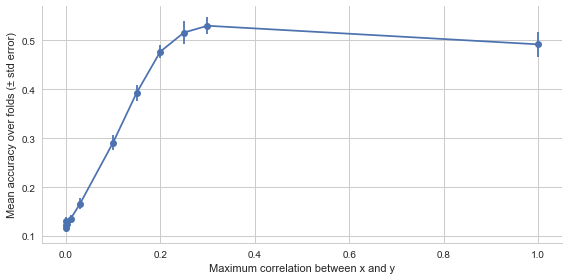

In [310]:
plot_data = accuracies_1_1.copy().reset_index()
plot_data = plot_data.groupby('max_corr_x_conf')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'max_corr_x_conf', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Maximum correlation between x and y')
g.axes[0,0].set_ylabel('Mean accuracy over folds (± std error)')

Remember, regressing out the confound in advance has the consequence that the correlation between X and y is 0. Clearly, starting out with a dataset with a correlation of 0 between x and confound is NOT a good idea! When the confound and y are perfectly correlated, the mean classification accuracy is 12.2% - far off the 50% we would expect.

## 1.2. Within-fold regression: remove confound within the folds
Another option is to regress out the confound within every fold. Thus, we do _not_ regress out _before_ K-fold cross-validation, but _within_ every fold of the cross-validation procedure. In this Section, we regress out the confound by fitting a regression model on the train set, and use the fitted confound regression model to transform both the train and the test set (i.e., within every fold)

In [311]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1.]

# For every value of 'max_corr_x_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate DataFrame for results
accuracies_1_2 = pd.DataFrame(index=pd.MultiIndex.from_product([max_corr_x_conf, np.arange(n_datasets)],
                                                               names=['max_corr_x_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# First, loop over the array of maximum correlations
for i, max_correlation in enumerate(max_corr_x_conf):
    print('Maximum correlation between x and the confound: %.4f' % max_correlation)
    
    # Loop over datasets
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        # Generate empty array X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        
        # Set default noise sd for generating X
        noise_sd = 1
        for ii in range(n_ind):

            # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than max_correlation.
            # Ideally, you would use something like np.random.bivariate_normal for this; but y is a binary variable 
            # in our case. Maybe this method can be used:
            # https://www.r-bloggers.com/easily-generate-correlated-variables-from-any-distribution-without-copulas/
            attempt = 0
            while True:
                attempt += 1
                random_vec = np.random.normal(0, noise_sd, n_obs)

                if np.abs(np.corrcoef(x=random_vec, y=y)[0,1]) < max_correlation:
                    X[:,ii] = random_vec
                    break

                if attempt > 10000:
                    # after 10.000 attempts at generting an X with the specified correlation with y, lower the amount of noise
                    noise_sd = noise_sd-.005
                    print('Tried 10000 generations, decreasing amount of noise...')

        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)
                
        # Initialize list for scores
        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]
            
            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=y, fit_idx=train_idx)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])

            pipe.fit(X_train, y_train)  # Fit pipeline
            fold_scores = pipe.score(X_test, y_test)  # Score
            scores.append(fold_scores)
        
        # Calculate mean accuracy for this dataset, and include in DataFrame
        scores = np.array(scores)
        accuracies_1_2.ix[max_correlation, dataset_num].loc['accuracy'] = scores.mean(axis=0)


Maximum correlation between x and the confound: 0.0001
Maximum correlation between x and the confound: 0.0003
Maximum correlation between x and the confound: 0.0010
Maximum correlation between x and the confound: 0.0030
Maximum correlation between x and the confound: 0.0100
Maximum correlation between x and the confound: 0.0300
Maximum correlation between x and the confound: 0.1000
Maximum correlation between x and the confound: 0.1500
Maximum correlation between x and the confound: 0.2000
Maximum correlation between x and the confound: 0.2500
Maximum correlation between x and the confound: 0.3000
Maximum correlation between x and the confound: 1.0000


Again, let's inspect the mean accuracies (i.e., mean across data sets)

In [312]:
accuracies_1_2.groupby('max_corr_x_conf').mean()

,accuracy
max_corr_x_conf,
0.0001,0.5
0.0003,0.5
0.0010,0.5
0.0030,0.5
0.0100,0.5
0.0300,0.5
0.1000,0.5
0.1500,0.5
0.2000,0.5


Visualize...

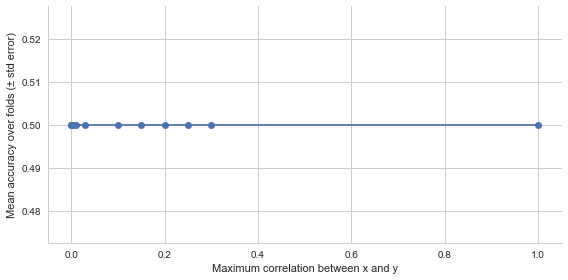

In [313]:
# Reshape for plotting
plot_data = accuracies_1_2.copy().reset_index()
plot_data = plot_data.groupby('max_corr_x_conf')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'max_corr_x_conf', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Maximum correlation between x and y')
g.axes[0,0].set_ylabel('Mean accuracy over folds (± std error)')

This works perfectly: all accuracies are exactly 50%.
#### NB: There is no variance, therefore, no error bars
There is no variance in prediction accuracy - it is 50% in every fold for every data set. The underlying reason is that, within the train set, there is an enforced correlation of 0 between x and y. The classifier cannot learn anything, and therefore, all parameters are 0 (except for some rounding error).
The consequence of setting all parameters to 0 is that a classifier always predicts either 1 or 0 (depending on the rounding error). As we are using stratified K-fold crossvalidation, this implies that accuracy is always 50%.

## 1.3. Remove confound within folds, separately for train and test set
A second option is to remove the confound within the folds but train a seperate regression model for the train and test set. Thus, within every fold of the cross-validation procedure, we train _two_ models: the first is fitted on the train set and transforms the train set, the second is fitted on the test set and transforms the test set.

In [314]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1.]

# For every value of 'max_corr_x_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate pd.DataFrame for results
accuracies_1_3 = pd.DataFrame(index=pd.MultiIndex.from_product([max_corr_x_conf, np.arange(n_datasets)],
                                                               names=['max_corr_x_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# First, loop over the array of maximum correlations
for i, max_correlation in enumerate(max_corr_x_conf):
    print('Maximum correlation between x and the confound: %.4f' % max_correlation)
    
    # Loop over datasets
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        # Generate empty array X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        
        # Set default noise sd for generating X
        noise_sd = 1
        for i in range(n_ind):

            # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than max_correlation.
            # Ideally, you would use something like np.random.bivariate_normal for this; but y is a binary variable 
            # in our case. Maybe this method can be used:
            # https://www.r-bloggers.com/easily-generate-correlated-variables-from-any-distribution-without-copulas/
            attempt = 0
            while True:
                attempt += 1
                random_vec = np.random.normal(0, noise_sd, n_obs)

                if np.abs(np.corrcoef(x=random_vec, y=y)[0,1]) < max_correlation:
                    X[:,i] = random_vec
                    break

                if attempt > 10000:
                    # after 10.000 attempts at generting an X with the specified correlation with y, lower the amount of noise
                    noise_sd = noise_sd-.005
                    print('Tried 10000 generations, decreasing amount of noise...')

        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)
                
        # Initialize list for scores
        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]
            
            # Set train idx in pipeline
            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=y, fit_idx=train_idx, cross_validate=False)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])

#            pipe.set_params(confreg__fit_idx=train_idx)
            pipe.fit(X_train, y_train)  # Fit pipeline
            fold_scores = pipe.score(X_test, y_test)  # Score
            scores.append(fold_scores)
        
        # Calculate mean accuracy for this dataset, and include in DataFrame
        scores = np.array(scores)
        accuracies_1_3.ix[max_correlation, dataset_num].loc['accuracy'] = scores.mean(axis=0)


Maximum correlation between x and the confound: 0.0001
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test


Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
F

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
F

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
F

Inspect mean accuracies

In [315]:
accuracies_1_3.groupby('max_corr_x_conf').mean()

,accuracy
max_corr_x_conf,
0.0001,0.5
0.0003,0.5
0.0010,0.5
0.0030,0.5
0.0100,0.5
0.0300,0.5
0.1000,0.5
0.1500,0.5
0.2000,0.5


Visualize

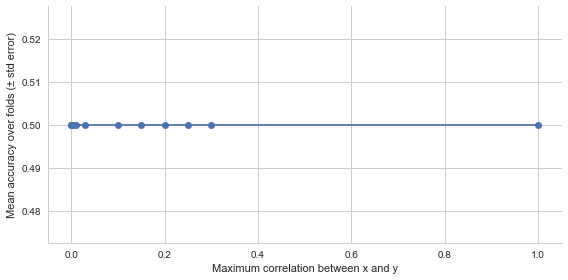

In [316]:
# Reshape for plotting
plot_data = accuracies_1_3.copy().reset_index()
plot_data = plot_data.groupby('max_corr_x_conf')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'max_corr_x_conf', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Maximum correlation between x and y')
g.axes[0,0].set_ylabel('Mean accuracy over folds (± std error)')

The results are identical to the results obtained before in Section 1.2. Again, there is no variance, due to the fact that the SVM is fitted on a dataset with _no_ correlation between y and X. The fitted parameters are therefore 0, and the SVM simply guesses the same class regardless of the test X. Because we use Stratified K-fold cross-validation with balanced classes, accuracy is always perfectly 50%.

# 2. Single confound, cor(confound, y) < 1

The results in Section 1 visualize the importance of allowing correlations between the X and y to exist before using a K-fold cross-validation procedure. However, we made the assumption that the correlation coefficient between y and the confound is 1. Therefore, although the results are interesting, it is not clear how the results of Section 1 generalize to cases where the confound and y do not correlate perfectly.

In this Section, we vary the correlation between y and the confound, and explore the effects of the three methods also used in Section 1: either regress the confound before performing a K-fold cross-validation routine; or do confound regression within every fold (a single model); or do confound regression within every fold with separate regression models for the train and test set.

### 2.1 Regress confound before K-fold CV

In [323]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# For every 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 30

# Pre-allocate pd.DataFrame for output accuracies
accuracies_2_1 = pd.DataFrame(index=pd.MultiIndex.from_product([corr_y_conf, np.arange(n_datasets)],
                                                               names=['corr_y_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation y/conf: %.3f ±.01' % corr_y_confound, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for ii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,ii] = random_vec
        
        # Regress out the confound from X
        X = ConfoundRegressor(confound=confound, fit_idx=range(n_obs)).fit_transform(X=X)
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_2_1.ix[corr_y_confound, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Correlation y/conf: 0.700 ±.01..............................
Correlation y/conf: 0.600 ±.01..............................
Correlation y/conf: 0.500 ±.01..............................
Correlation y/conf: 0.400 ±.01..............................
Correlation y/conf: 0.300 ±.01..............................
Correlation y/conf: 0.200 ±.01..............................
Correlation y/conf: 0.100 ±.01..............................

Inspect mean accuracies

In [324]:
accuracies_2_1.groupby('corr_y_conf').mean()

,accuracy
corr_y_conf,
0.1,0.498333
0.2,0.481333
0.3,0.508333
0.4,0.469667
0.5,0.438333
0.6,0.415000
0.7,0.399667


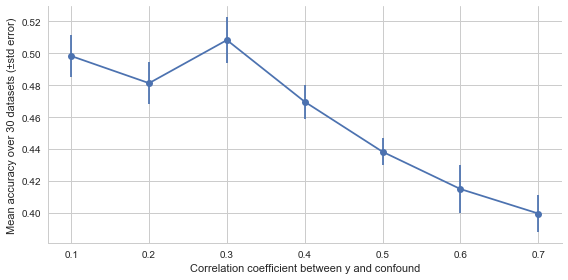

In [325]:
# Reshape for plotting
plot_data = accuracies_2_1.copy().reset_index()
plot_data = plot_data.groupby('corr_y_conf')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'corr_y_conf', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Correlation coefficient between y and confound')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)

These results clearly show that regressing out a confound before K-fold cross-validation leads to sub-chance accuracy levels starting from correlation coefficients of about 0.4. **Importantly**, the number of independent variables is **fixed** here to 25 - the results above do **NOT** warrant any conclusion that performing confound regression betfore K-fold cross-valdiation is a valid procedure as long as the correlation coefficient between the confound and y is lower than 0.4

Section 3 explores what happens if we increase the number of independent variables (but fix the correlation coefficient between y and the confound). Section 4 explores the effects of several combinations of independent variables and correlation coefficients between y and the confound.

#### 2.2 What happens if we regress out the confound within every fold?

In [326]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# For every 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 30

# Pre-allocate pd.DataFrame for output accuracies
accuracies_2_2 = pd.DataFrame(index=pd.MultiIndex.from_product([corr_y_conf, np.arange(n_datasets)],
                                                               names=['corr_y_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation y/conf: %.3f ±.01' % corr_y_confound, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
                
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_2_2.ix[corr_y_confound, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Correlation y/conf: 0.700 ±.01..............................
Correlation y/conf: 0.600 ±.01..............................
Correlation y/conf: 0.500 ±.01..............................
Correlation y/conf: 0.400 ±.01..............................
Correlation y/conf: 0.300 ±.01..............................
Correlation y/conf: 0.200 ±.01..............................
Correlation y/conf: 0.100 ±.01..............................

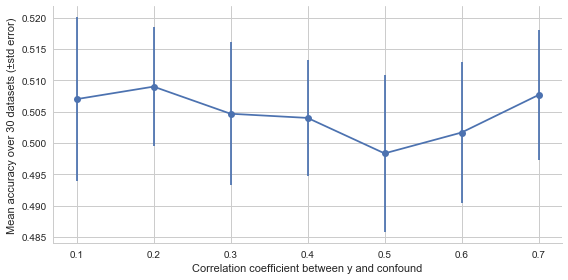

In [327]:
# Reshape for plotting
plot_data = accuracies_2_2.copy().reset_index()
plot_data = plot_data.groupby('corr_y_conf')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'corr_y_conf', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Correlation coefficient between y and confound')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)

This is the situation we like: after regressing out the confound, there is a 50% accuracy, _regardless_ of the correlation between y and the confound. The results show correctly that there is no relation between X and y.

#### 2.3 And what happens if we regress out the confound within every fold, but separately on the train and test set?

In [328]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# For every 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 30

# Pre-allocate pd.DataFrame for output accuracies
accuracies_2_3 = pd.DataFrame(index=pd.MultiIndex.from_product([corr_y_conf, np.arange(n_datasets)],
                                                               names=['corr_y_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation y/conf: %.3f ±.01' % corr_y_confound, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
                
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=False)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_2_3.ix[corr_y_confound, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Correlation y/conf: 0.700 ±.01.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately o

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on te

.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on te

Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on tes

.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

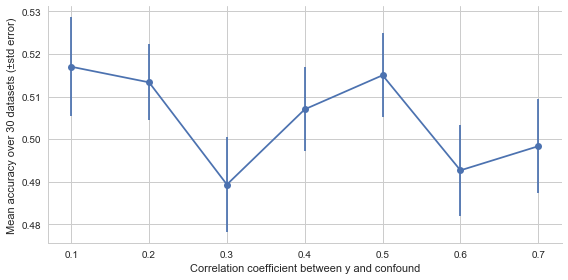

In [329]:
# Reshape for plotting
plot_data = accuracies_2_3.copy().reset_index()
plot_data = plot_data.groupby('corr_y_conf')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'corr_y_conf', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Correlation coefficient between y and confound')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)

These results are the same as in Section 2.2. Regressing out the confound, separately for the train and test set, within every fold, does not lead to a below-chance accuracy.

# 3. Varying the number of independent variables
In empirical MVPA situations, you often need to select a number of features from your (f)MRI data. The correlation between any y and confound is, on the other hand, fixed. This section explores what the influence is of confound regression, given different numbers of selected features.

In Section 3, we set the correlation coefficient between y and the confound to 0.6. This is a correlation coefficient found in empirical data (i.e., the point-biserial correlation between brain size and gender is 0.645). In Section 4, we also vary the correlation coefficient between y and the confound.

### 3.1 Regress confound before K-fold CV

In [331]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_confound = .6

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate pd.DataFrame for output accuracies
accuracies_3_1 = pd.DataFrame(index=pd.MultiIndex.from_product([n_independent_vars, np.arange(n_datasets)],
                                                               names=['n_independent_vars', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, n_ind in enumerate(n_independent_vars):
    print('\nNumber of independent variables: %d' % n_ind, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
        
        # Regress out the confound from X
        X = ConfoundRegressor(confound=confound, fit_idx=range(n_obs)).fit_transform(X=X)
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_3_1.ix[n_ind, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........

Plot the data

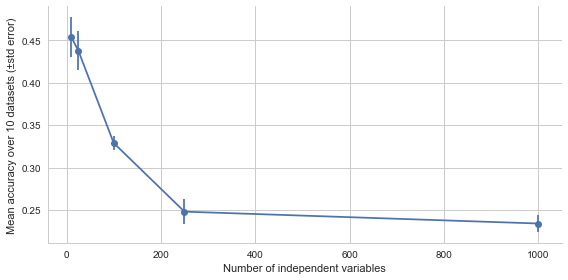

In [332]:
# Reshape for plotting
plot_data = accuracies_3_1.copy().reset_index()
plot_data = plot_data.groupby('n_independent_vars')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'n_independent_vars', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Number of independent variables')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)

The graph above illustrates that higher numbers of independent variables (for a fixed correlation between y and the confound) leads to worse sub-chance classification accuracies.

#### 3.2 Now, regress within folds

In [336]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_confound = .645

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate pd.DataFrame for output accuracies
accuracies_3_2 = pd.DataFrame(index=pd.MultiIndex.from_product([n_independent_vars, np.arange(n_datasets)],
                                                               names=['n_independent_vars', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, n_ind in enumerate(n_independent_vars):
    print('\nNumber of independent variables: %d' % n_ind, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=True)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_3_2.ix[n_ind, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........

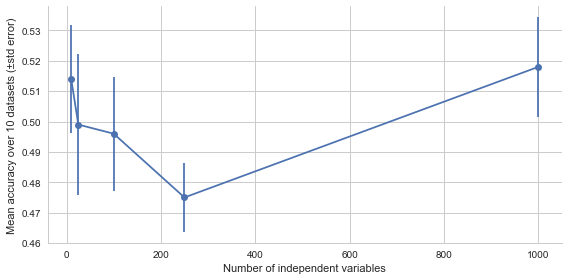

In [337]:
# Reshape for plotting
plot_data = accuracies_3_2.copy().reset_index()
plot_data = plot_data.groupby('n_independent_vars')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'n_independent_vars', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Number of independent variables')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)

Regressing out the confound within every fold does exactly what we want: regardless of the number of independent variables, the classification accuracy is ± 50%. This correctly shows that there is no relation between X and y.

#### 3.3 For the sake of completeness, also regress out within every fold for the train and test set separately

In [338]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_confound = .645

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate pd.DataFrame for output accuracies
accuracies_3_3 = pd.DataFrame(index=pd.MultiIndex.from_product([n_independent_vars, np.arange(n_datasets)],
                                                               names=['n_independent_vars', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, n_ind in enumerate(n_independent_vars):
    print('\nNumber of independent variables: %d' % n_ind, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=False)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_3_3.ix[n_ind, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Number of independent variables: 10.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separat

Number of independent variables: 250.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separat

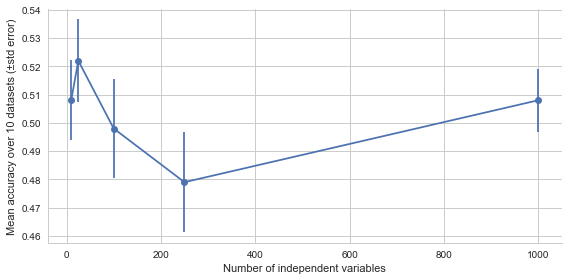

In [339]:
# Reshape for plotting
plot_data = accuracies_3_3.copy().reset_index()
plot_data = plot_data.groupby('n_independent_vars')['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Plot with seaborn
g = sns.FacetGrid(plot_data, size=4, aspect=2)
g.map(plt.errorbar, 'n_independent_vars', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Number of independent variables')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)

The results of this method are similar to the results of Section 3.2.

### 4 Vary number of independent variables and correlation between y and confound
In this section, we combine Sections 2 and 3. Both the number of independent variables and the correlation between y and confound are varied, and the results are shown in a single graph.

#### 4.1 Regress out confound before K-fold cross-validation

In [271]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000, 2500, 10000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_4_1 = pd.DataFrame(index=pd.MultiIndex.from_product([n_independent_vars, corr_y_conf, np.arange(n_datasets)],
                                                               names=['n_independent_vars', 'corr_y_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation between y and confound: %.1f (±.01)' % corr_y_confound)

    for ii, n_ind in enumerate(n_independent_vars):
        print('\nNumber of independent variables: %d' % n_ind, end='')

        # Loop over datasets; 10 x per allowed_correlation
        for dataset_num in range(n_datasets):

            # Generate y first
            y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

            attempt_y_conf = 1
            noise_sd = 1
            while True:
                confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
                attempt_y_conf += 1

                # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
                if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                    if silent:
                        print('.', end='')
                    else:
                        print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                    break

                if attempt_y_conf > 1000000:
                    noise_sd = noise_sd-.005
                    if silent:
                        print('-', end='')
                    else:
                        print('Tried 1000000 generations, decreasing amount of noise...')

            # Generate random X of size (n_obs, n_ind)
            X = np.ndarray((n_obs, n_ind))
            noise_sd = 1
            for iii in range(n_ind):
                # Generate random vector.
                random_vec = np.random.normal(0, noise_sd, n_obs)
                X[:,iii] = random_vec

            # Regress out the confound from X
            X = ConfoundRegressor(confound=confound, fit_idx=range(n_obs)).fit_transform(X=X)

            # 10-fold stratified CV
            cv = StratifiedKFold(n_splits=n_splits)

            # Pipeline
            pipe = Pipeline([('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])

            scores = []
            for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
                X_train = X[train_idx,:]
                X_test = X[test_idx,:]
                y_train = y[train_idx]
                y_test = y[test_idx]

                pipe.fit(X_train, y_train)
                fold_score = pipe.score(X_test, y_test)
                scores.append(fold_score)

            scores = np.array(scores)
            accuracies_4_1.ix[n_ind, corr_y_confound, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Correlation between y and confound: 0.7 (±.01)

Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........
Number of independent variables: 2500..........
Number of independent variables: 10000..........
Correlation between y and confound: 0.6 (±.01)

Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........
Number of independent variables: 2500..........
Number of independent variables: 10000..........
Correlation between y and confound: 0.5 (±.01)

Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number 

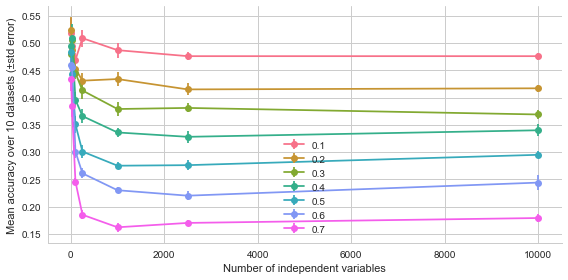

In [273]:
# Some re-shaping
plot_data = accuracies_4_1.copy()
plot_data = plot_data.reset_index().groupby(['n_independent_vars', 'corr_y_conf'])['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Seaborn 
g = sns.FacetGrid(plot_data, hue='corr_y_conf', size=4, aspect=2)
g.map(plt.errorbar, 'n_independent_vars', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Number of independent variables')  #'Correlation coefficient between y and confound')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)
g.axes[0,0].legend()

This graph combines the results of Section 2.1 and Section 3.1: the higher the amount of independent variables, the larger the problem of sub-chance accuracy. Similarly, the higher the correlation between y and the confound, the larger the problem of sub-chance accuracy.

#### 4.2 Regressing out confound within folds

In [340]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000, 2500, 10000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_4_2 = pd.DataFrame(index=pd.MultiIndex.from_product([n_independent_vars, corr_y_conf, np.arange(n_datasets)],
                                                               names=['n_independent_vars', 'corr_y_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation between y and confound: %.1f (±.01)' % corr_y_confound)

    for ii, n_ind in enumerate(n_independent_vars):
        print('\nNumber of independent variables: %d' % n_ind, end='')

        # Loop over datasets; 10 x per allowed_correlation
        for dataset_num in range(n_datasets):

            # Generate y first
            y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

            attempt_y_conf = 1
            noise_sd = 1
            while True:
                confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
                attempt_y_conf += 1

                # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
                if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                    if silent:
                        print('.', end='')
                    else:
                        print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                    break

                if attempt_y_conf > 1000000:
                    noise_sd = noise_sd-.005
                    if silent:
                        print('-', end='')
                    else:
                        print('Tried 1000000 generations, decreasing amount of noise...')

            # Generate random X of size (n_obs, n_ind)
            X = np.ndarray((n_obs, n_ind))
            noise_sd = 1
            for iii in range(n_ind):
                # Generate random vector.
                random_vec = np.random.normal(0, noise_sd, n_obs)
                X[:,iii] = random_vec

            # 10-fold stratified CV
            cv = StratifiedKFold(n_splits=n_splits)

            scores = []
            for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
                X_train = X[train_idx,:]
                X_test = X[test_idx,:]
                y_train = y[train_idx]
                y_test = y[test_idx]

                pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=True)),
                                 ('scale', StandardScaler()), 
                                 ('svc', SVC(kernel='linear'))])
                pipe.fit(X_train, y_train)
                fold_score = pipe.score(X_test, y_test)
                scores.append(fold_score)

            scores = np.array(scores)
            accuracies_4_2.ix[n_ind, corr_y_confound, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Correlation between y and confound: 0.7 (±.01)

Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........
Number of independent variables: 2500..........
Number of independent variables: 10000..........
Correlation between y and confound: 0.6 (±.01)

Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........
Number of independent variables: 2500..........
Number of independent variables: 10000..........
Correlation between y and confound: 0.5 (±.01)

Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number 

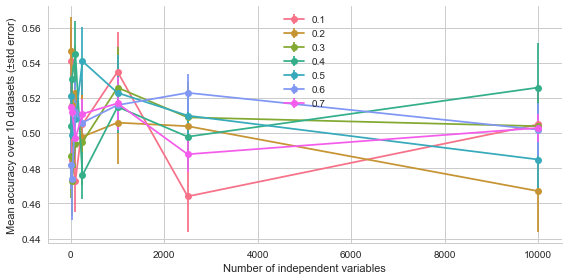

In [341]:
# Some re-shaping
plot_data = accuracies_4_2.copy()
plot_data = plot_data.reset_index().groupby(['n_independent_vars', 'corr_y_conf'])['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Seaborn
g = sns.FacetGrid(plot_data, hue='corr_y_conf', size=4, aspect=2)
g.map(plt.errorbar, 'n_independent_vars', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Number of independent variables')  #'Correlation coefficient between y and confound')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)
g.axes[0,0].legend()

The results are nicely in line with what we expect. Regardless of:

- the number of independent variables;
- the correlation coefficient between y and the confound;
- any interaction between the above two factors;

confound regression within folds leads to a 50% accuracy.

#### 4.3 Regress out confound within folds, but separately for train and test set

In [342]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000, 2500, 10000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_4_3 = pd.DataFrame(index=pd.MultiIndex.from_product([n_independent_vars, corr_y_conf, np.arange(n_datasets)],
                                                               names=['n_independent_vars', 'corr_y_conf', 'dataset']),
                              columns=['accuracy'], dtype=float)

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation between y and confound: %.1f (±.01)' % corr_y_confound)

    for ii, n_ind in enumerate(n_independent_vars):
        print('\nNumber of independent variables: %d' % n_ind, end='')

        # Loop over datasets; 10 x per allowed_correlation
        for dataset_num in range(n_datasets):

            # Generate y first
            y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

            attempt_y_conf = 1
            noise_sd = 1
            while True:
                confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
                attempt_y_conf += 1

                # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
                if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                    if silent:
                        print('.', end='')
                    else:
                        print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                    break

                if attempt_y_conf > 1000000:
                    noise_sd = noise_sd-.005
                    if silent:
                        print('-', end='')
                    else:
                        print('Tried 1000000 generations, decreasing amount of noise...')

            # Generate random X of size (n_obs, n_ind)
            X = np.ndarray((n_obs, n_ind))
            noise_sd = 1
            for iii in range(n_ind):
                # Generate random vector.
                random_vec = np.random.normal(0, noise_sd, n_obs)
                X[:,iii] = random_vec

            # 10-fold stratified CV
            cv = StratifiedKFold(n_splits=n_splits)

            scores = []
            for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
                X_train = X[train_idx,:]
                X_test = X[test_idx,:]
                y_train = y[train_idx]
                y_test = y[test_idx]

                pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=False)),
                                 ('scale', StandardScaler()), 
                                 ('svc', SVC(kernel='linear'))])
                pipe.fit(X_train, y_train)
                fold_score = pipe.score(X_test, y_test)
                scores.append(fold_score)

            scores = np.array(scores)
            accuracies_4_3.ix[n_ind, corr_y_confound, dataset_num].loc['accuracy'] = scores.mean(axis=0)



Correlation between y and confound: 0.7 (±.01)

Number of independent variables: 10.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on

Fitting separately on test

Number of independent variables: 250.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separa

Fitting separately on test
Fitting separately on test

Number of independent variables: 10000.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting sepa

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test

Number of independent variables: 100.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separa

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test

Number of independent variables: 2500.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separ

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on te

.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

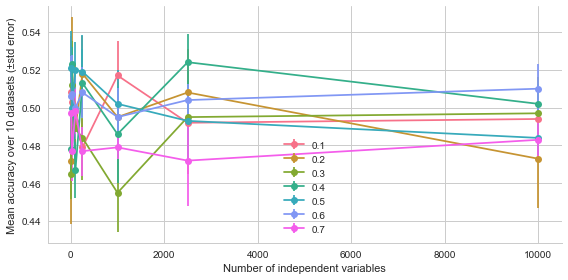

In [343]:
# Some re-shaping
plot_data = accuracies_4_3.copy()
plot_data = plot_data.reset_index().groupby(['n_independent_vars', 'corr_y_conf'])['accuracy'].aggregate([np.mean, stats.sem]).reset_index()

# Seaborn 
g = sns.FacetGrid(plot_data, hue='corr_y_conf', size=4, aspect=2)
g.map(plt.errorbar, 'n_independent_vars', 'mean', 'sem', marker='o')  # add error bars
g.axes[0,0].set_xlabel('Number of independent variables')  #'Correlation coefficient between y and confound')
g.axes[0,0].set_ylabel('Mean accuracy over %d datasets (±std error)' % n_datasets)
g.axes[0,0].legend()

These results are similar to the results of Section 4.2.

# The End